In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
#split text into sentences
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [ ]:
#function to read raw text file
def read_text(filename):
   #open the file
   file = open(filename, mode='rt', encoding="utf-8")
   #read all text
   text= file.read()
   file.close()
   return text

In [ ]:
data = read_text("/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [ ]:
deu_eng = deu_eng[:50000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["I don't like Tom.", 'Ich mag Tom nicht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2261946 (CK) & #3892767 (Pfirsichbaeumchen)'],
       ["I don't like him.", 'Ich mag ihn nicht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #354256 (Hautis) & #724919 (Esperantostern)'],
       ["I don't like rum.", 'Ich mag keinen Rum.', 'CC-BY 2.0 (F']],
      dtype='<U101')

In [ ]:
 #empty lists
 eng_1 = []
 deu_1 = []

 #populate the lists with sentence lengths
 for i in deu_eng[:,0]:
   eng_1.append(len(i.split()))

 for i in deu_eng[:,1]:
   deu_1.append(len(i.split()))

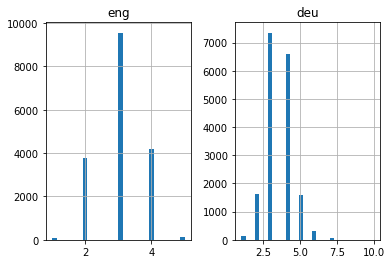

In [ ]:
length_df = pd.DataFrame({'eng':eng_1, 'deu':deu_1})

length_df.hist(bins = 30)
plt.show()

In [ ]:
#function to buid a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' %eng_vocab_size)


English Vocabulary Size: 3245


In [ ]:
#prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' %deu_vocab_size)

Deutch Vocabulary Size: 5176


In [ ]:
#encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  #integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [ ]:
from sklearn.model_selection import train_test_split
train, test=train_test_split(deu_eng, test_size=0.2, random_state=12)

In [ ]:
#prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
#prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
#build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences = True))
  model.add(Dense(out_vocab, activation ='softmax'))
  return model


In [ ]:

model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
filename = 'model.h1.19_palvisha'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose = 1, save_best_only = True, mode = 'min' )

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs = 2, batch_size = 512,
          validation_split = 0.2,
          callbacks = [checkpoint], verbose=1)

Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 3.5274
Epoch 00001: val_loss improved from inf to 2.78265, saving model to model.h1.19_palvisha


INFO:tensorflow:Assets written to: model.h1.19_palvisha/assets


INFO:tensorflow:Assets written to: model.h1.19_palvisha/assets


23/23 [==============================] - 71s 3s/step - loss: 3.5274 - val_loss: 2.7826
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 2.3665
Epoch 00002: val_loss improved from 2.78265 to 2.29764, saving model to model.h1.19_palvisha


INFO:tensorflow:Assets written to: model.h1.19_palvisha/assets


INFO:tensorflow:Assets written to: model.h1.19_palvisha/assets


23/23 [==============================] - 70s 3s/step - loss: 2.3665 - val_loss: 2.2976


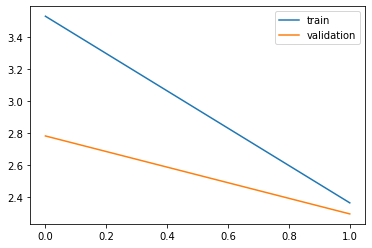

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
model = load_model('model.h1.19_palvisha')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if (index == n).any() :
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t)

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
# print 15 rows randomly
pred_df.head(15)

NameError: ignored